In [ ]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

<h1 align=center><font size = 5 color='blue'>Chargement et préparation des données</font></h1>

In [ ]:
data=pd.read_csv('../data/yelp-text-by-stars.csv',sep=';',encoding="ISO-8859-1")
data.head(3)

,Stars,Text
0,1,Boarded my English Mastiff here over New Year'...
1,1,Another case of the Emperor's New Clothes. So...
2,1,Came on Valentine's Day night having pre-bough...


In [ ]:
corpus=data.iloc[:,1].values
Y=data.iloc[:,0].values

In [ ]:
print('Taille du corpus : {0:d}'.format(len(corpus)))

Taille du corpus : 47371


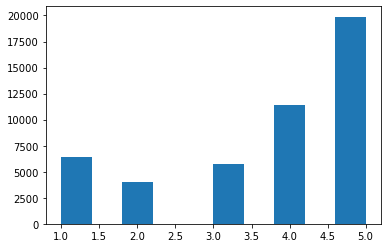

In [ ]:
plt.hist(Y)
plt.show()

### Découpage de la base en Apprentissage et test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
corpus_train,corpus_test,y_train,y_test=train_test_split(corpus,Y,test_size=0.33,shuffle=True,random_state=1)

<h1 align=center><font size = 5 color='blue'>Création des modèles d'apprentissage</font></h1>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error,accuracy_score,confusion_matrix

In [ ]:
algos = {
'RF' : RandomForestRegressor(n_estimators=50,random_state=1,n_jobs=-1),
 'KNN' : KNeighborsRegressor(n_neighbors=5,n_jobs=-1,metric='cosine'),
  'MLP' : MLPRegressor(hidden_layer_sizes=(20,10),max_iter=200,random_state=1,alpha=0.001)
}

def run_models (X_train,Y_train,X_test,Y_test,algos):
    for algo_name in algos:
        model=algos[algo_name]
        model.fit(X_train,Y_train)
        prediction=model.predict(X_test)
        prediction[prediction<1]=1
        prediction[prediction>5]=5
        MAE=mean_absolute_error(Y_test,prediction)
        ACC=accuracy_score(Y_test,np.round(prediction))

        print('################## {0} #############'.format(algo_name))
        print('MAE = {0:.3f}, Accuracy ={1:.3f}'.format(MAE,ACC))
        display(confusion_matrix(Y_test,np.round(prediction)))
        print()


<h1 align=center><font size = 5 color='blue'>Vectorisation des textes par TF-IDF</font></h1>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer

In [ ]:
#CV=CountVectorizer(max_features=1000,stop_words='english')
#CV.fit(corpus_train)
#corpus_train_CV=CV.transform(corpus_train)
#TFIDF=TfidfTransformer()
#TFIDF.fit(corpus_train_CV)
#corpus_train_tfidf=TFIDF.transform(corpus_train_CV)


TFIDF=TfidfVectorizer(max_features=1000,stop_words='english')
TFIDF.fit(corpus_train)
corpus_train_tfidf=TFIDF.transform(corpus_train)
corpus_test_tfidf=TFIDF.transform(corpus_test)


In [ ]:
corpus_train_tfidf[0].toarray() # Pour afficher le premier texte transformé par TFIDF

In [ ]:
CV.vocabulary_ # Pour afficher le vocabulaire gardé par TFIDF

In [ ]:
TFIDF.get_feature_names()[17]  # Pour afficher le 18eme mot du vocabulaire

In [ ]:
# pour compléter la liste des stop words par défaut de sklearn

from sklearn.feature_extraction import _stop_words
_stop_words.ENGLISH_STOP_WORDS
new_stop_words=_stop_words.ENGLISH_STOP_WORDS.union(frozenset({'30','40'}))



In [ ]:
run_models (corpus_train_tfidf.toarray(),y_train,corpus_test_tfidf.toarray(),y_test,algos)

################## RF #############
MAE = 0.735, Accuracy =0.457


array([[ 587,  841,  472,  221,   23],
       [  78,  405,  514,  337,   44],
       [  34,  213,  722,  822,   96],
       [   8,  104,  612, 2217,  720],
       [   8,  104,  456, 2779, 3216]])


################## KNN #############
MAE = 0.918, Accuracy =0.361


array([[ 271,  632,  707,  440,   94],
       [  62,  242,  507,  496,   71],
       [  28,  153,  600,  931,  175],
       [   9,  105,  756, 2049,  742],
       [  16,  133,  921, 3013, 2480]])


################## MLP #############
MAE = 0.752, Accuracy =0.507


array([[1250,  445,  202,  141,  106],
       [ 371,  361,  302,  224,  120],
       [ 167,  339,  468,  589,  324],
       [ 114,  255,  511, 1311, 1470],
       [ 141,  234,  377, 1270, 4541]])

<h1 align=center><font size = 5 color='blue'>Sélection de mots clés pertinents</font></h1>

['great' 'worst' 'told' 'amazing' 'best' 'rude' 'horrible' 'delicious'
 'love' 'good' 'friendly' 'terrible' 'awesome' 'excellent' 'asked'
 'highly' 'definitely' 'said' 'ok' 'food' 'bland' 'nice' 'bad' 'place'
 'poor' 'just' 'wasn' 'perfect' 'don' 'minutes']


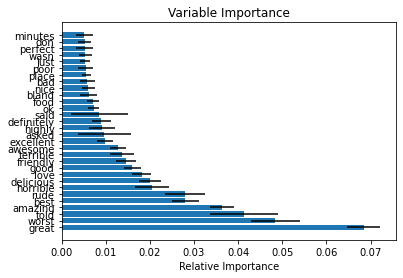

In [ ]:
X_array=corpus_train_tfidf.toarray()
features =np.asarray(TFIDF.get_feature_names())
clf=RandomForestRegressor(n_estimators=500,random_state=1,n_jobs=-1)
nb_best=30

clf.fit(X_array, y_train)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
print(features[sorted_idx][:nb_best])
padding = np.arange(nb_best) + 0.5
plt.barh(padding, importances[sorted_idx][:nb_best],xerr=std[sorted_idx][:nb_best], align='center')
plt.yticks(padding, features[sorted_idx][:nb_best])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

<h1 align=center><font size = 5 color='blue'>Vectorisation des textes par SVD</font></h1>

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
SVD=TruncatedSVD(n_components=100)
SVD.fit(corpus_train_tfidf)
corpus_train_SVD=SVD.transform(corpus_train_tfidf)
corpus_test_SVD=SVD.transform(corpus_test_tfidf)

In [ ]:
SVD.components_[0,:].shape

(1000,)

In [ ]:
corpus_train_SVD.shape

(31738, 100)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Concept %d: " % topic_idx
        message += " ".join([feature_names[i]+'('+str(np.round(topic[i],2))+')' for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print_top_words(SVD, TFIDF.get_feature_names(), 5)

Concept 0: food(0.23) good(0.22) great(0.21) place(0.21) service(0.17)
Concept 1: food(0.37) good(0.25) great(0.18) chicken(0.15) delicious(0.13)
Concept 2: great(0.58) service(0.19) staff(0.19) friendly(0.19) love(0.14)
Concept 3: pizza(0.45) love(0.31) place(0.31) best(0.12) like(0.1)
Concept 4: pizza(0.75) service(0.21) great(0.15) customer(0.11) crust(0.11)
Concept 5: good(0.55) pizza(0.3) really(0.12) pretty(0.12) service(0.11)
Concept 6: great(0.52) room(0.15) bar(0.11) nice(0.11) burger(0.1)
Concept 7: good(0.49) recommend(0.15) chicken(0.15) car(0.14) friendly(0.14)
Concept 8: staff(0.36) friendly(0.29) room(0.26) hotel(0.21) nice(0.18)
Concept 9: staff(0.38) friendly(0.36) love(0.19) place(0.12) order(0.12)
Concept 10: amazing(0.33) good(0.25) time(0.24) burger(0.24) recommend(0.16)
Concept 11: sushi(0.47) place(0.42) recommend(0.17) service(0.14) rolls(0.12)
Concept 12: love(0.5) service(0.4) burger(0.2) customer(0.19) room(0.18)
Concept 13: love(0.44) chicken(0.21) good(0.2)

In [ ]:
run_models (corpus_train_SVD,y_train,corpus_test_SVD,y_test,algos)

################## RF #############
MAE = 0.793, Accuracy =0.413


array([[ 292,  862,  752,  220,   18],
       [  36,  303,  684,  332,   23],
       [   6,  155,  881,  783,   62],
       [   5,   70,  839, 2262,  485],
       [   7,   90,  692, 3051, 2723]])


################## KNN #############
MAE = 0.872, Accuracy =0.389


array([[ 502,  763,  600,  248,   31],
       [ 103,  340,  527,  356,   52],
       [  43,  251,  759,  720,  114],
       [  26,  202,  992, 1846,  595],
       [  34,  237, 1031, 2623, 2638]])


################## MLP #############
MAE = 0.661, Accuracy =0.516


array([[ 875,  780,  301,  158,   30],
       [ 185,  451,  463,  239,   40],
       [  44,  296,  658,  783,  106],
       [  13,  142,  616, 1942,  948],
       [  16,  123,  354, 1933, 4137]])

<h1 align=center><font size = 5 color='blue'>Vectorisation par Word2Vec entrainé</font></h1>

<h1 align=center><font size = 5 color='blue'>Vectorisation Word2Vec pre-entrainé de Google</font></h1>

<h1 align=center><font size = 5 color='blue'>Prédiction par LSTM</font></h1>